In [1]:
import os

import numpy as np
import cv2
import keras
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input


from ResNetAttentionInceptionBlocksDifferentBnorm import get_network as RNetInceptionBNorm
from ResNetAttentionInceptionBlocks import get_network as RNetInception
from ResNetAttention import get_network as RNet

def rename_layers(model, sufix):
    for i, layer in enumerate(model.layers):
        name = layer.name.split('_')[:-1]
#         name = "_".join(name)
#         print(name)
#         layer.name = name + "_" + sufix + "_" + str(i)
        layer.name = sufix + "_" + str(i)
        
def load_img(path):
    x = cv2.imread(path, 0)
    x = cv2.resize(x, (600, 1100))#, mode='constant', preserve_range=True)
    x = x.reshape((1100, 600, 1))
    return x

def get_final_prediction(predictions):
    class_votes = []
    confidence = []
    for result in res:
        class_votes.append(result[0])
        confidence.append(result[1])

    confidence = np.array(confidence)
    class_votes = np.array(class_votes)
    class_name, votes = np.unique(class_votes, return_counts = True)
    max_ind = np.argmax(votes)

    max_vote_indices = np.where(class_votes==class_name[max_ind])
    other_vote_indices = np.where(class_votes!=class_name[max_ind])
    conf_subset = confidence[max_vote_indices]
    conf_oposite_subset = confidence[other_vote_indices]

/home/user/Nucleus-segmentation/env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Renaming and saving models with different layer names

In [2]:
model_dict = {
    'first' : (RNet, '../checkpoints/ResidualAttentionNetSmallDifferentInterpolationCenterLoss/MicroblinkBasePreprocessorImgaugCenterLoss/2018-04-18__18_22_29_0.901/0.0341-0011.hdf5'),    
    'second' : (RNet, '../checkpoints/ResidualAttentionNetSmallDifferentInterpolationCenterLoss/MicroblinkBasePreprocessorImgaugCenterLoss/2018-04-19__12_47_26/0.0434-0021.hdf5'),    
    'third' : (RNet, '../checkpoints/ResidualAttentionNetSmallDifferentInterpolationCenterLoss/MicroblinkBasePreprocessorImgaugCenterLoss/2018-04-20__14_20_47/0.0158-0042.hdf5'),    
    'fourth' : (RNet, '../checkpoints/ResidualAttentionNetSmallDifferentInterpolationCenterLoss/MicroblinkBasePreprocessorImgaugCenterLoss/2018-04-24__17_55_22/0.0202-0023.hdf5'),  
    'fifth' : (RNetInception, '../checkpoints/ResidualAttentionInceptionReductionNetSmallDifferentInterpolationCenterLoss/MicroblinkBasePreprocessorImgaugCenterLoss/2018-04-23__17_57_30_nije_toliko_dobar/0.0307-0014.hdf5'),  
    'sixth' : (RNetInception, '../checkpoints/ResidualAttentionInceptionReductionNetSmallDifferentInterpolationCenterLoss/MicroblinkBasePreprocessorImgaugCenterLoss/2018-04-23__13_07_32/0.0294-0019.hdf5'),
    'seventh' : (RNetInceptionBNorm, '../checkpoints/ResidualAttentionInceptionReductionNetSmallDifferentInterpolationCenterLoss/MicroblinkBasePreprocessorImgaugCenterLoss/2018-04-24__12_01_45BatchNorm/0.0259-0023.hdf5')
}

key = 'first'
m = model_dict[key][0]()
m.load_weights(model_dict[key][1], by_name = True, skip_mismatch = True)
rename_layers(m, key)
m.save_weights('%s_model.hdf5'%key)

In [3]:
res = m.predict(np.expand_dims(load_img('/home/user/Mozgalo/inputs/test/0.jpg'), axis=0))
res = res[0]
print(res[np.argmax(res)])

0.92527735


# Reconstruct full ensemble

In [4]:
import time
model_dict = {
    'first' : (RNet, './models/first_model.hdf5'),    
    'second' : (RNet, './models/second_model.hdf5'),    
    'third' : (RNet, './models/third_model.hdf5'),    
    'fourth' : (RNet, './models/fourth_model.hdf5'),     
    'fifth' : (RNetInception, './models/fifth_model.hdf5'), 
    'sixth' : (RNetInception, './models/sixth_model.hdf5'), 
    'seventh' : (RNetInceptionBNorm, './models/seventh_model.hdf5'),
}

inp = Input((1100,600,1))
model_outputs = []
start = time.time()
for key in model_dict.keys():
    model = model_dict[key][0]()
    rename_layers(model, key)
    model.load_weights(model_dict[key][1], by_name = True, skip_mismatch = True)
    model_outputs.append(model(inp))
    
model_ensemble = Model([inp], model_outputs)
model_ensemble.compile(loss = ['categorical_crossentropy'] * len(model_outputs), optimizer='adam') #random loss because it is just ensembling it will not be trained further

print("Required time to ensemble models = %s" %(time.time()-start))
model_ensemble.summary()

Required time to ensemble models = 130.50552201271057
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1100, 600, 1) 0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 25)           1178937     input_2[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 25)           1239129     input_2[0][0]                    
__________________________________________________________________________________________________
model_3 (Model)                 (None, 25)           1239129     input_2[0][0]                    
_______________________________________________________

In [2]:
from sklearn import preprocessing

classes = ['Costco',
 'Meijer',
 'HarrisTeeter',
 'KingSoopers',
 'ShopRite',
 'JewelOsco',
 'SamsClub',
 'HyVee',
 'BJs',
 'Safeway',
 'Target',
 'HEB',
 'Kroger',
 'WholeFoodsMarket',
 'StopShop',
 'FredMeyer',
 'Wegmans',
 'Walmart',
 'Frys',
 'CVSPharmacy',
 'Walgreens',
 'Publix',
 'WinCoFoods',
 'Smiths',
 'Albertsons']

le = preprocessing.LabelEncoder()
le.fit(classes)
# pred = model_ensemble.predict(np.zeros((1,1100,600,1)))

LabelEncoder()

  0%|          | 0/10000 [00:00<?, ?it/s]

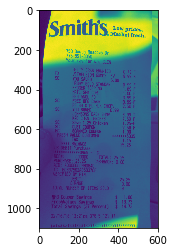

17 0.78229165


ValueError: could not broadcast input array from shape (25) into shape (1)

In [4]:
root = '../inputs/test'
sorting_func = lambda x: int(x.split('/')[-1].split('.')[0])
threshold = 0.95 # 0.95 resnet s center lossom dao 0.901
results = []
confidence = []
original_results = []
cnt_others = 0

# model_ensemble = RNetInceptionBNorm()
model_ensemble = ResidualAttentionInceptionReductionNetSmallDifferentInterpolationCenterLoss()
model_ensemble = model_ensemble.get_network()
# rename_layers(model_ensemble, 'seventh')
model_ensemble.load_weights('../checkpoints/ResidualAttentionInceptionReductionNetSmallDifferentInterpolationCenterLoss/MicroblinkBasePreprocessorImgaugCenterLoss/2018-04-24__12_01_45BatchNorm/0.0259-0023.hdf5', by_name = True)

for file_name in tqdm(sorted(os.listdir(root), key = sorting_func)):
    full_path = os.path.join(root, file_name)
    image = load_img(full_path)
    plt.imshow(np.squeeze(image))
    plt.show()
    image = np.expand_dims(image, axis=0)
    preds = model_ensemble.predict([image,np.random.rand(1,1)])[0][0]
    print(np.argmax(preds), preds[np.argmax(preds)])
    res = np.array(model_ensemble.predict([image,np.random.rand(1,1)]))#.reshape(7,25)
    print(res)
    max_indices = np.argmax(res, axis=1)
    confidences = res[range(len(max_indices)),max_indices]
    print(max_indices)
    class_names = le.inverse_transform(max_indices)
    print(list(zip(class_names,confidences)))
#     print(res[range(len(max_indices)),max_indices])
#     print(np.argmax(res, axis=1))
#     print(le.inverse_transform([17]))
    break

In [4]:
model_ensemble.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1100, 600, 1) 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1100, 600, 1) 0           input_1[0][0]                    
__________________________________________________________________________________________________
classification_conv_1 (Conv2D)  (None, 550, 300, 8)  400         lambda_1[0][0]                   
__________________________________________________________________________________________________
classification_maxpool_1 (MaxPo (None, 275, 150, 8)  0           classification_conv_1[0][0]      
__________________________________________________________________________________________________
batch_norm